In [1]:
# Import modules
import numpy as np

# Import functions
from assembly_A_local_global_matrices import *
from assembly_K_matrices import *
from assembly_B_matrices import *
from assembly_f_vectors import *
from RegularSudomainsMesh import RegularSubdomainsMesh
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# Import data
d_dat = np.genfromtxt('data/d.dat')
fP_dat = np.genfromtxt('data/fP.dat')
fr_dat = np.genfromtxt('data/fr.dat')
Ks = np.genfromtxt('data/localK.dat')
solution = np.genfromtxt('data/solution.dat')

In [3]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])
qs_left_bound = np.array([0, 8])
qs_right = np.array([3, 11])

In [4]:
# Create mesh
mesh = RegularSubdomainsMesh(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [5]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(mesh)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(mesh)

# Dirichlet nodes local-global transformation matrices
ADd = create_ADq_matrices(mesh)

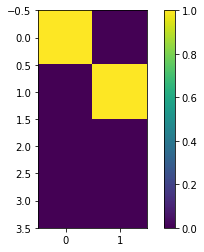

In [6]:
plot_sparse_matrix(ADd[0])

In [7]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs, mesh)
KPP = assembly_KPP_matrix(Ks, APq, qs, qs_right, mesh)
KRP = assembly_KRP_matrix(Ks, APq, ARr, qs, qs_right, rs, mesh)
KPR = KRP.T

In [8]:
KPD = assembly_KPD_matrix(Ks, APq, ADd, qs_left_bound, qs_right, mesh)
KRD = assembly_KRD_matrix(Ks, ARr, ADd, qs_left_bound, rs, mesh)

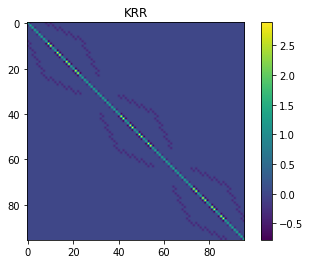

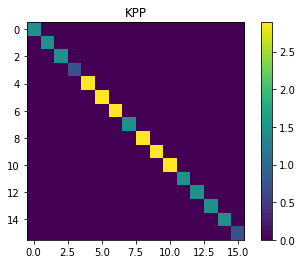

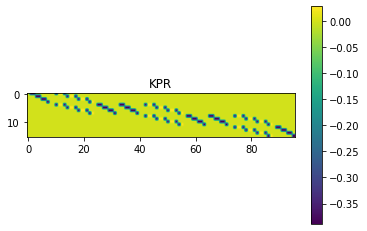

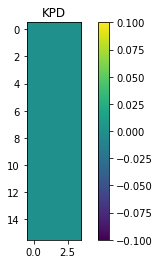

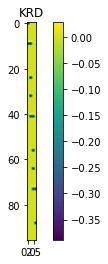

In [9]:
# Plot K matrices
plot_sparse_matrix(KRR, 'KRR')
plot_sparse_matrix(KPP, 'KPP')
plot_sparse_matrix(KPR, 'KPR')
plot_sparse_matrix(KPD, 'KPD')
plot_sparse_matrix(KRD, 'KRD')

In [10]:
# Assembly B matrices
BlambdaR = assembly_BR_matrix(mesh, ARr)

# Dirichlet boundary conditions
# Left wall remaining
BlambdaR = assembly_Dirichlet_BR_matrix(mesh, ARr, BlambdaR)

#Left wall primal
# BlambdaP = assembly_Dirichlet_BP_matrix(mesh, ADd)

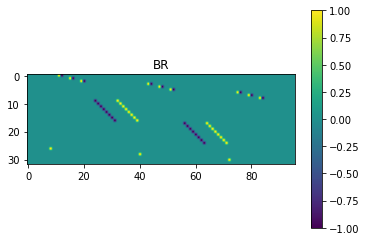

In [11]:
# Plot B matrices
plot_sparse_matrix(BlambdaR, 'BR')
#plot_sparse_matrix(BlambdaP, 'BP')

In [12]:
# Assembly d vector
d = np.zeros(mesh.Nlambda)
d[mesh.NlambdaR:] = d_dat

In [13]:
# Assembly f vectors
# fP
fP, fD = assembly_fP_fD_vectors(mesh, fP_dat)

# fR
fR = assembly_fR_vector(mesh, fr_dat)

In [14]:
# Assembly uD vector
uD = d_dat[np.arange(len(d_dat)) % (mesh.Nr_y - 1) == 0]

In [33]:
# Matrices pre computation
KRR_inv = np.linalg.inv(KRR)

SPP = KPP - KPR @ KRR_inv @ KRP
SPP_inv = np.linalg.inv(SPP)

fPH = fP - KPD @ uD
fRH = fR - KRD @ uD

IR = np.eye(mesh.NR) # RxR identity matrix

dH = d - BlambdaR @ KRR_inv @ ((IR + KRP @ SPP_inv @ KPR @ KRR_inv) @ fRH - KRP @ SPP_inv @ fPH)
F = -BlambdaR @ KRR_inv @ (KRP @ SPP_inv @ KPR @ KRR_inv + IR) @ BlambdaR.T

In [35]:
np.shape(dH)

(32,)

In [17]:
# Matrices pre computation
# KRR_inv = np.linalg.inv(KRR)

# SPP = KPP - KPR @ KRR_inv @ KRP
# SPP_inv = np.linalg.inv(SPP)

# fPH = fP - KPR @ KRR_inv @ fR

# dH = -d \
#     + BlambdaP @ SPP_inv @ fPH \
#     + BlambdaR @ KRR_inv @ fR \
#     - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ fPH

# F = BlambdaR @ KRR_inv @ BlambdaR.T \
#     + BlambdaR @ KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
#     + BlambdaP @ SPP_inv @ BlambdaP.T \
#     - BlambdaP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
#     - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ BlambdaP.T

NameError: name 'BlambdaP' is not defined

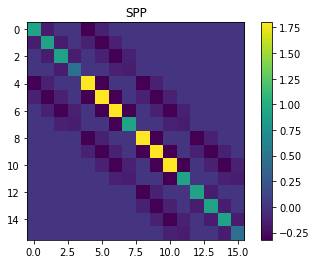

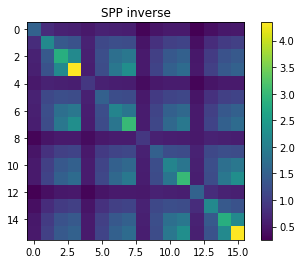

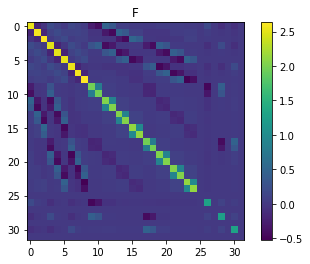

In [ ]:
# Print some matrices
plot_sparse_matrix(SPP, 'SPP')
plot_sparse_matrix(SPP_inv, 'SPP inverse')
plot_sparse_matrix(F, 'F')

In [ ]:
# Solve lambda linear system
lambda_ = np.linalg.solve(F, dH)

LinAlgError: Singular matrix

In [ ]:
# Compute u
# uP
uP = SPP_inv @ fPH \
    + SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ \
    - SPP_inv @ BlambdaP.T @ lambda_

# uR
uR = KRR_inv @ fR \
    + KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ fR \
    - KRR_inv @ KRP @ SPP_inv @ fP \
    - KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ \
    + KRR_inv @ KRP @ SPP_inv @ BlambdaP.T @ lambda_ \
    - KRR_inv @ BlambdaR.T @ lambda_

In [ ]:
# Print result
print('uP', uP)
print('uR', uR)

In [ ]:
# TODO: Set solutions uP and uR together in a single array u